# Lithology Masks

This notebook generates the required lithology input files to GEOCLIM from GLiM + LiMW.

In [1]:
import datetime
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from matplotlib import cm
from tqdm import tqdm_notebook

## Functions

In [2]:
def plot_z(z, lat, lon, zlabel, coastlines=False, output=False, **kwargs):
    """
    Plot data.

    Parameters
    ----------
    z : array
        the data (unsnaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    zlabel : string
        label for the colorbar
        
    coastlines : boolean
        set whether coastlines will be drawn (default False)
        
    output : boolean
        if true, return the figure and axis handles (default False)
        
    **kwargs
        passed to plt.pcolormesh()
    """
    #wrap the longitude vector around an arbitary point in order to fix non-plotting issue on date line
    wrapped_lon = np.concatenate([lon[5:],lon[:5]])
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)

    fig = plt.figure(figsize=(15,6))

    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    if coastlines:
        ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 color='gray', alpha=0.5, linestyle='--')

    im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree(), **kwargs)
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), **kwargs)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(zlabel, rotation=270, labelpad=20)

    if output!=False:
        return fig, ax

In [3]:
def snake_it(array, filename=None):
    """
    Convert a netcdf variable into a single column vector, and save to text file.

    Parameters
    ----------
    array : netcdf variable, or array
        Must be 2d. Ensure that the array is (lat,lon).
        
    filename : string
        if set, the snake will be saved with filename.

    Returns
    -------
    snaked : single column array
    """
    dim = np.shape(array)
    if len(dim)!=2:
        print('The array does not have 2 dimensions! Nothing returned.')
    else:
        snaked = np.array([])
        for i in range(dim[0]):
            for j in range(dim[1]):
                snaked = np.append(snaked, array[i,j])
        if filename != None:
            np.savetxt(filename, snaked, newline='\n')
        return snaked

In [4]:
def plot_snake(snake, lat, lon, zlabel):
    """
    Plot snaked data (by unsnaking it first).

    Parameters
    ----------
    snake : array
        the data (snaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    zlabel : string
        label for the colorbar
    """
    dim = (len(lat), len(lon))
    unsnaked = np.ones(shape=dim)
    for i in range(dim[0]):
        for j in range(dim[1]):
            unsnaked[i,j] = snake[dim[1]*i+j]

    plot_z(unsnaked, lat, lon, zlabel)

In [5]:
def plot_lithology(lith_mask, lat, lon, projection=ccrs.PlateCarree(), coastlines=False, output=False):
    """
    Plot lithology data.

    Parameters
    ----------
    lith_mask : array
        the lithological mask (unsnaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    projection : cartopy projection
        as ccrs.XXX()
      
    coastlines : boolean
        set whether coastlines will be drawn (default False)
        
    output : boolean
        if true, return the figure and axis handles (default False)
    """
    z = lith_mask
    
    # wrap the longitude vector around an arbitary point in order to fix non-plotting issue on date line
    wrapped_lon = np.concatenate([lon[5:],lon[:5]])
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)

    # set up the figure
    fig = plt.figure(figsize=(15,6))
    ax = plt.subplot(1,1,1, projection=projection)
    if coastlines:
        ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 color='gray', alpha=0.5, linestyle='--')
    
    # set up the discrete colormap
    cmap = colors.ListedColormap(['gainsboro',
                                  'mediumseagreen',
                                  'pink',
                                  'darkorange',
                                  'orangered',
                                  'dodgerblue',
                                  'C7'])
    bounds = np.arange(-0.5,7.5,1)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # plot the data
    im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    
    # add the colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_ticks(np.arange(7))
    cbar.set_ticklabels(['0 = water/ice',
                         '1 = metamorphics',
                         '2 = felsics',
                         '3 = intermediates',
                         '4 = mafics',
                         '5 = carbonates',
                         '6 = sediments'])

    if output!=False:
        return fig, ax

In [6]:
def plot_CaMg(lith_mask, lat, lon, projection=ccrs.PlateCarree(), coastlines=False, output=False, **kwargs):
    """
    Plot Ca+Mg.

    Parameters
    ----------
    lith_mask : array
        the lithological mask (unsnaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    projection : cartopy projection
        as ccrs.XXX()
      
    coastlines : boolean
        set whether coastlines will be drawn (default False)
        
    output : boolean
        if true, return the figure and axis handles (default False)
        
    **kwargs
        passed to plt.pcolormesh()
    """
    CaMg_vals = np.array([0, 3390, 1521, 4759, 10317, 0, 2235])
    
    z = np.zeros((len(lat), len(lon)))
    
    for i in range(len(CaMg_vals)):
        z = z + lith_mask[:,:,i] * CaMg_vals[i]
    
    #wrap the longitude vector around an arbitary point in order to fix non-plotting issue on date line
    wrapped_lon = np.concatenate([lon[5:],lon[:5]])
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)

    fig = plt.figure(figsize=(15,6))

    ax = plt.subplot(1,1,1, projection=projection)
    if coastlines:
        ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 color='gray', alpha=0.5, linestyle='--')

    im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree(), **kwargs)
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), **kwargs)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('PRELIMINARY\nmean Ca+Mg [mol/m$^{3}$]', rotation=270, labelpad=20)

    if output!=False:
        return fig, ax

## LiMW

This file was rasterized in QGIS at 3600x1800 resolution (0.1x0.1 degree) from the raw LiMW shapefile:

In [7]:
LiMW = Dataset('../Input/LiMW_3600_1800.nc')
dim_raw = np.shape(LiMW.variables['Band1'][:,:])
print(dim_raw)

(1800, 3600)


| ID | code | description                     | classification |
|----|------|---------------------------------|----------------|
| 1  | su   | unconsolidated sediments        | 6              |
| 2  | vb   | basic volcanic rocks            | 4              |
| 3  | ss   | siliciclastic sedimentary rocks | 6              |
| 4  | pb   | basic plutonic rocks            | 4              |
| 5  | sm   | mixed sedimentary rocks         | 6              |
| 6  | sc   | carbonate sedimentary rocks     | 5              |
| 7  | va   | acid volcanic rocks             | 2              |
| 8  | mt   | metamorphics                    | 1              |
| 9  | pa   | acid plutonic rocks             | 2              |
| 10 | vi   | intermediate volcanic rocks     | 3              |
| 11 | wb   | water bodies                    | 0              |
| 12 | py   | pyroclastics                    | 2              |
| 13 | pi   | intermediate plutonic rocks     | 3              |
| 14 | ev   | evaporites                      | 5              |
| 15 | nd   | no data                         | 1              |
| 16 | ig   | ice and glaciers                | 0              |

Our classification code:

* 0 = ocean/water/ice
* 1 = metamorphics
* 2 = felsics
* 3 = intermediates
* 4 = mafics
* 5 = carbonates
* 6 = siliciclastics

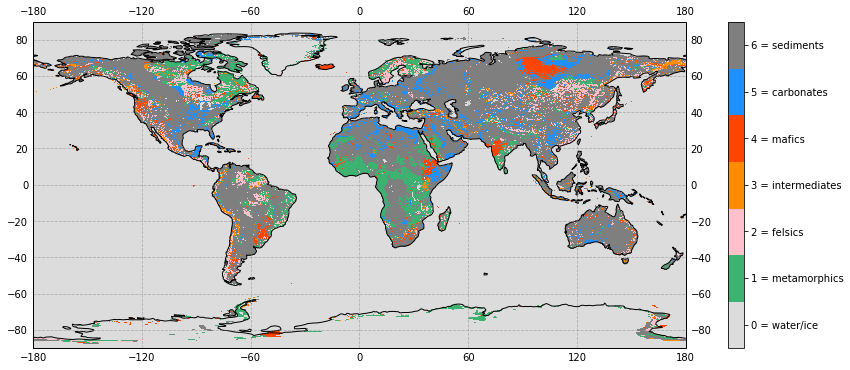

In [8]:
LiMW_Band1 = LiMW.variables['Band1'][:,:].data
LiMW_Band1[LiMW_Band1>6] = 0

LiMW_lat = LiMW.variables['lat'][:].data
LiMW_lon = LiMW.variables['lon'][:].data

plot_lithology(LiMW_Band1, LiMW_lat, LiMW_lon,
               coastlines=True, output=False)

### Lithology Mask

In [9]:
# initialize the lithologic mask (lat, lon, lith)
lith_mask = np.zeros((360, 720, 7))

for i in range(360):
    for j in range(720):
        
        # get the 5x5 cell that fits into the 0.5x0.5 degree cell in the lithologic mask
        LiMW_Band1_cell = LiMW_Band1[i*5:(i+1)*5,j*5:(j+1)*5]
        
        # count number of cells of each lithology
        for k in range(7):
            lith_mask[i,j,k] = np.sum(LiMW_Band1_cell==k)
            
# make the values fraction of the 1x1 cell
lith_mask = lith_mask/25

In [10]:
lat = np.linspace(-89.75,89.75,360)
lon = np.linspace(-179.75,179.75,720)

dim = (360,720)

lith_class = ['0 = water/ice',
              '1 = metamorphics',
              '2 = felsics',
              '3 = intermediates',
              '4 = mafics',
              '5 = carbonates',
              '6 = sediments']

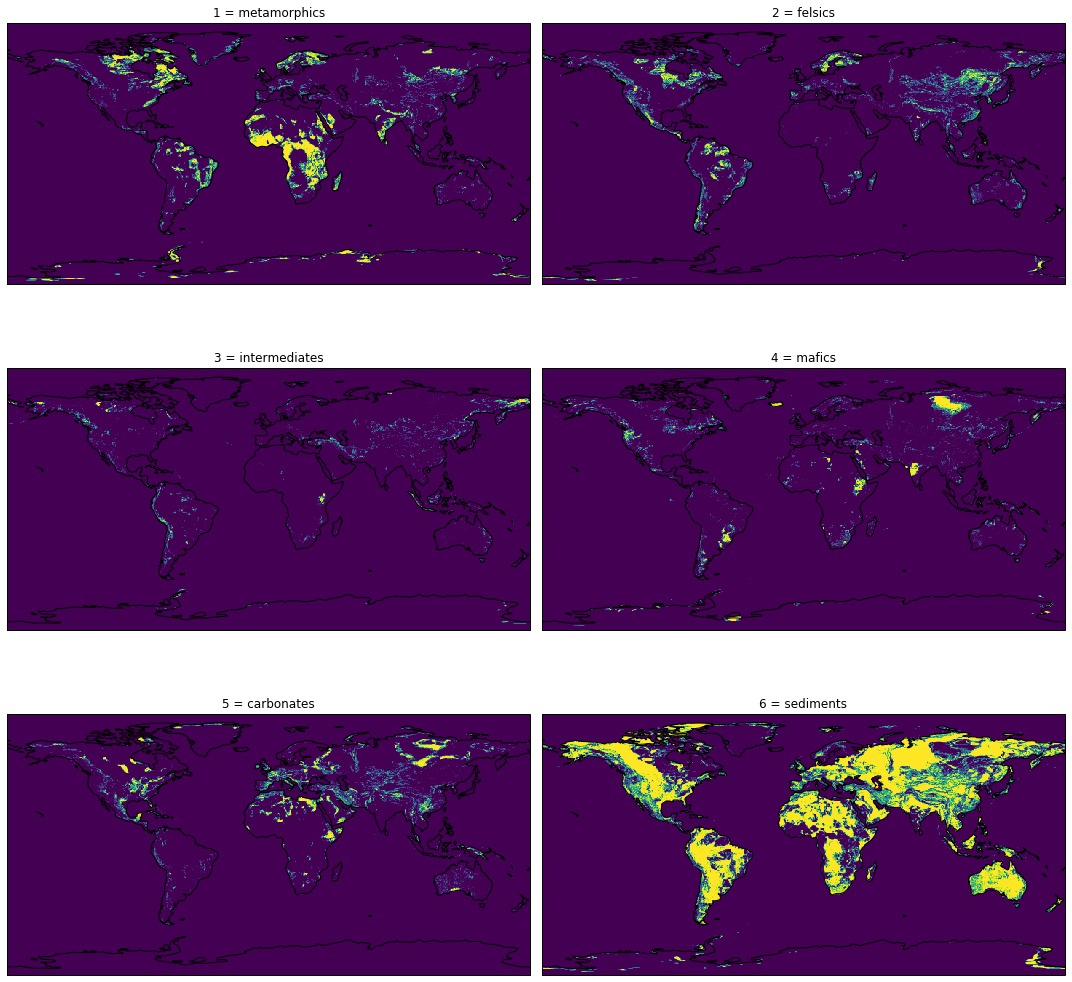

In [11]:
fig = plt.figure(figsize=(15,15))

wrapped_lon = np.concatenate([lon[5:],lon[:5]])

for i in range(1,7):
    ax = plt.subplot(3,2,i, projection=ccrs.PlateCarree())
    
    z = lith_mask[:,:,i]
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)
    ax.coastlines()
    im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree())
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree())
    
    ax.set_title(lith_class[i])
    
fig.tight_layout()
plt.show(fig)

Output as netCDF:

In [12]:
# initialize netCDF
lith_mask_nc = Dataset('../Output/lith_mask.nc', 'w', format='NETCDF4')
lith_mask_nc.description = 'lithologic mask'

# create dimensions
lith_mask_nc.createDimension('lon', 720)
lith_mask_nc.createDimension('lat', 360)
lith_mask_nc.createDimension('lith', 7)

# initialize variables
lon_var = lith_mask_nc.createVariable('lon', 'f', ('lon',))
lat_var = lith_mask_nc.createVariable('lat', 'f', ('lat',))
lith_var = lith_mask_nc.createVariable('lith', 'i', ('lith',))
frac_var = lith_mask_nc.createVariable('frac', 'f', ('lith','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lith_var.long_name = 'lithology'
frac_var.long_name = 'lithology area fraction'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lith_var.units = 'lithology'
frac_var.units = 'fraction'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lith_var.axis = 'Z'

# fill variables
lon_var[:] = lon
lat_var[:] = lat
lith_var[:] = np.arange(7, dtype=np.int8)
frac_var[:,:,:] = np.transpose(lith_mask.copy(), (2,0,1))
    
lith_mask_nc.close()

## Grid Area

Create a grid area mask:

In [13]:
cell_area = np.zeros(shape=dim)

# authalic radius of the Earth in m
Earth_R = 6371.0072 * 1000

lat_mins = np.linspace(-90,90,361)

# iterate through latitudes
for i in range(dim[0]):
    cell_area[i] = np.abs(np.sin(np.deg2rad(lat_mins[i]))-np.sin(np.deg2rad(lat_mins[i+1])))*\
                   np.deg2rad(0.5)*Earth_R**2
    
# a mask that has an area for every cell (ocean + land)
land_area = cell_area.copy()
    
# mask non-land areas
land_area = land_area * (1 - lith_mask[:,:,0])

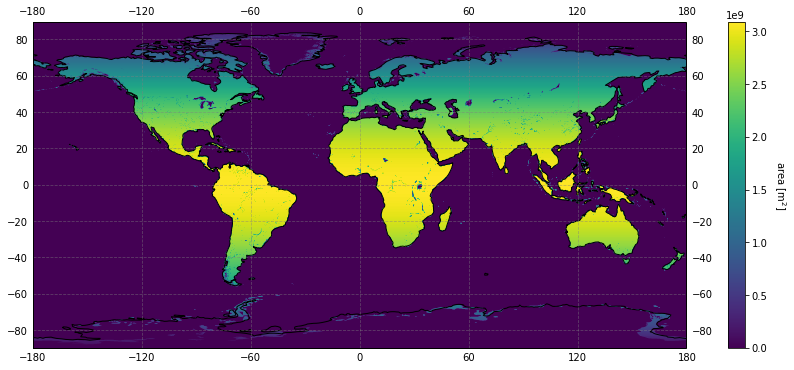

In [14]:
plot_z(land_area, lat, lon, 'area [m$^{2}$]', coastlines=True, output=False)

In [15]:
total_land_area = np.sum(land_area) / 1e6 / 1e6

total_area_1 = np.sum(lith_mask[:,:,1] * cell_area) / 1e6 / 1e6
total_area_2 = np.sum(lith_mask[:,:,2] * cell_area) / 1e6 / 1e6
total_area_3 = np.sum(lith_mask[:,:,3] * cell_area) / 1e6 / 1e6
total_area_4 = np.sum(lith_mask[:,:,4] * cell_area) / 1e6 / 1e6
total_area_5 = np.sum(lith_mask[:,:,5] * cell_area) / 1e6 / 1e6
total_area_6 = np.sum(lith_mask[:,:,6] * cell_area) / 1e6 / 1e6

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_1,
                                                                        (total_area_1/total_land_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_2,
                                                                        (total_area_2/total_land_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_3,
                                                                        (total_area_3/total_land_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_4,
                                                                        (total_area_4/total_land_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_5,
                                                                        (total_area_5/total_land_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(total_area_6,
                                                                        (total_area_6/total_land_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(total_land_area))

metamorphic   : area = 19.65 e6 km^2, perc. = 14.8
felsic        : area = 11.02 e6 km^2, perc. =  8.3
intermediate  : area =  3.16 e6 km^2, perc. =  2.4
mafic         : area =  6.26 e6 km^2, perc. =  4.7
carbonate     : area = 11.32 e6 km^2, perc. =  8.5
siliciclastic : area = 81.67 e6 km^2, perc. = 61.4

total         : area = 133.09 e6 km^2


Output as netCDF:

In [16]:
# initialize netCDF
cell_area_nc = Dataset('../Output/cell_area.nc', 'w', format='NETCDF4')
cell_area_nc.description = 'Area of each 0.5x0.5 cell.'

# create dimensions
cell_area_nc.createDimension('lon', 720)
cell_area_nc.createDimension('lat', 360)

# initialize variables
lon_var = cell_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = cell_area_nc.createVariable('lat', 'f', ('lat',))
area_var = cell_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon
lat_var[:] = lat
area_var[:,:] = cell_area
    
cell_area_nc.close()

In [17]:
# initialize netCDF
land_area_nc = Dataset('../Output/land_area.nc', 'w', format='NETCDF4')
land_area_nc.description = 'Area of land in each 0.5x0.5 cell.'

# create dimensions
land_area_nc.createDimension('lon', 720)
land_area_nc.createDimension('lat', 360)

# initialize variables
lon_var = land_area_nc.createVariable('lon', 'f', ('lon',))
lat_var = land_area_nc.createVariable('lat', 'f', ('lat',))
area_var = land_area_nc.createVariable('area', 'f', ('lat','lon',))

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
area_var.long_name = 'area'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
area_var.units = 'm^2'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon
lat_var[:] = lat
area_var[:,:] = land_area
    
land_area_nc.close()

**MASKS HAVE TO BE REMADE**

## Maritime Continent Mask

In [ ]:
fig, ax = plot_z(grid_area, lat, lon, 'area [1e6 km$^{2}$]', coastlines=True, output=True)

ax.set_xlim(85,165)
ax.set_ylim(-20,25)

# Maritime Continent area extent
s_ind = 79
n_ind = 110
w_ind = 275
e_ind = 338
ax.axhline(lat[s_ind], ls='--', c='grey')
ax.axhline(lat[n_ind], ls='--', c='grey')
ax.axvline(lon[w_ind], ls='--', c='grey')
ax.axvline(lon[e_ind], ls='--', c='grey')

# Borneo
s_ind_b = 85
n_ind_b = 97
w_ind_b = 288
e_ind_b = 299
#ax.axhline(lat[s_ind_b], ls='--', c='r')
#ax.axhline(lat[n_ind_b], ls='--', c='r')
#ax.axvline(lon[w_ind_b], ls='--', c='r')
#ax.axvline(lon[e_ind_b], ls='--', c='r')

# mainland asia
s_ind_c = 96
n_ind_c = n_ind
w_ind_c = w_ind
e_ind_c = 291
#ax.axhline(lat[s_ind_c], ls='--', c='orange')
#ax.axhline(lat[n_ind_c], ls='--', c='orange')
#ax.axvline(lon[w_ind_c], ls='--', c='orange')
#ax.axvline(lon[e_ind_c], ls='--', c='orange')

# used to see where the Malay peninsula is - it's not a box
#lat_ind = 93
#w_ind_d = 280
#e_ind_d = 285
#ax.axhline(lat[lat_ind], ls='--', c='orange')
#ax.axhline(lat[lat_ind+1], ls='--', c='orange')
#ax.axvline(lon[w_ind_d], ls='--', c='orange')
#ax.axvline(lon[e_ind_d], ls='--', c='orange')

plt.show()

In [ ]:
MC_mask = np.zeros(shape=dim)

for i in np.arange(s_ind,n_ind):
    for j in np.arange(w_ind,e_ind):
        if grid_area[i,j] != 0:
            # Borneo
            if   i>=s_ind_b and i<n_ind_b and j>=w_ind_b and j<e_ind_b:
                pass
            # mainland asia
            elif i>=s_ind_c and i<n_ind_c and j>=w_ind_c and j<e_ind_c:
                pass
            # the following are for the Malay peninsula
            elif i==91 and j>=283 and j<284:
                pass
            elif i==92 and j>=282 and j<284:
                pass
            elif i==93 and j>=281 and j<284:
                pass
            elif i==94 and j>=281 and j<284:
                pass
            elif i==95 and j>=280 and j<284:
                pass
            elif i==96 and j>=280 and j<282:
                pass
            else:
                MC_mask[i,j] = 1
                
fig, ax = plot_z(MC_mask, lat, lon, 'mask', coastlines=True, output=True)

ax.set_xlim(85,165)
ax.set_ylim(-20,25)

plt.show()

What gets removed?

In [ ]:
MC_mask_area = np.sum(MC_mask*grid_area)

MC_mask_area_1 = np.sum((MC_mask*grid_area)[lith_mask==1])
MC_mask_area_2 = np.sum((MC_mask*grid_area)[lith_mask==2])
MC_mask_area_3 = np.sum((MC_mask*grid_area)[lith_mask==3])
MC_mask_area_4 = np.sum((MC_mask*grid_area)[lith_mask==4])
MC_mask_area_5 = np.sum((MC_mask*grid_area)[lith_mask==5])
MC_mask_area_6 = np.sum((MC_mask*grid_area)[lith_mask==6])

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(MC_mask_area_1,
                                                                        (MC_mask_area_1/MC_mask_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(MC_mask_area_2,
                                                                        (MC_mask_area_2/MC_mask_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(MC_mask_area_3,
                                                                        (MC_mask_area_3/MC_mask_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(MC_mask_area_4,
                                                                        (MC_mask_area_4/MC_mask_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(MC_mask_area_5,
                                                                        (MC_mask_area_5/MC_mask_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(MC_mask_area_6,
                                                                        (MC_mask_area_6/MC_mask_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(MC_mask_area))

### noMC = no Maritime Continent

#### lithology

In [ ]:
lith_mask_noMC = lith_mask.copy()
lith_mask_noMC[MC_mask==1] = 0
plot_lithology(lith_mask_noMC, lat, lon, coastlines=True)

In [ ]:
lith_mask_noMC_snake = snake_it(lith_mask_noMC, '../Output/lith_mask_noMC.dat')

In [ ]:
plot_snake(lith_mask_noMC_snake, lat, lon, 'lithologic class')

#### area

In [ ]:
grid_area_noMC = grid_area.copy()
grid_area_noMC[MC_mask==1] = 0
plot_z(grid_area_noMC, lat, lon, 'area [1e6 km$^{2}$]', coastlines=True)

In [ ]:
grid_area_noMC_snake = snake_it(grid_area_noMC, '../Output/grid_area_noMC.dat')

In [ ]:
plot_snake(grid_area_noMC_snake, lat, lon, 'area [1e6 km$^{2}$]')

In [ ]:
check_mask_coherence(lith_mask_noMC, grid_area_noMC)

### redMC_PM = reduced Maritime Continent

from Molnar et al. (2015):

> As summarized in Table 1, the region between 95°E and 154°E (from just west of Sumatra to just west
of Bougainville) and between 12°N and 12°S, comprises 17.38 × 10$^{6}$ km$^{2}$. Today, 17.9% of this area or
3.10 × 10$^{6}$ km$^{2}$ stands above sea level, but at 5 Ma, only 11.2% or 1.94 × 10$^{6}$ km$^{2}$ had emerged (Figure 2). Thus, the emergent fraction has increased by 60% or 1.16 × 10$^{6}$ km$^{2}$; this new land is roughly equal to the combined area of France and Spain, or the combined area of the four-corners states in the USA (Utah, Colorado, Arizona, and New Mexico).

In [ ]:
MC_land_area = 0
n_MC_pixels = 0
for i in range(len(lat)):
    for j in range(len(lon)):
        if MC_mask[i,j] == 1:
            MC_land_area = MC_land_area + grid_area[i,j]
            n_MC_pixels = n_MC_pixels + 1
print('area of Maritime Continent in our model          : ' + str(np.round(MC_land_area,2)) + ' e6 km2')
print('number of Maritime Continent pixels in our model : ' + str(n_MC_pixels))

In [ ]:
fig, ax = plot_z(MC_mask, lat, lon, 'mask', coastlines=True, output=True)

ax.set_xlim(85,165)
ax.set_ylim(-20,25)

# used to see where my indexes are
lat_ind = 84
w_ind_d = 314
e_ind_d = 325
ax.axhline(lat[lat_ind], ls='--', c='orange')
ax.axhline(lat[lat_ind+1], ls='--', c='orange')
ax.axvline(lon[w_ind_d], ls='--', c='orange')
ax.axvline(lon[e_ind_d], ls='--', c='orange')

plt.show()

In [ ]:
redMC_PM_mask = MC_mask.copy()

for i in np.arange(s_ind,n_ind):
    for j in np.arange(w_ind,e_ind):
        if grid_area[i,j] != 0 and MC_mask[i,j] == 1:
            # PNG
            if   i==80 and j>=320 and j<330:
                redMC_PM_mask[i,j] = 0
            elif i==81 and j>=318 and j<324:
                redMC_PM_mask[i,j] = 0
            elif i==82 and j>=318 and j<326:
                redMC_PM_mask[i,j] = 0
            elif i==83 and j>=314 and j<325:
                redMC_PM_mask[i,j] = 0
            elif i==84 and j>=314 and j<324:
                redMC_PM_mask[i,j] = 0
            elif i==85 and j>=316 and j<322:
                redMC_PM_mask[i,j] = 0
            elif i==86 and j>=317 and j<319:
                redMC_PM_mask[i,j] = 0
            # Indonesia
            if   i==80 and j>=299 and j<305:
                redMC_PM_mask[i,j] = 0
            elif i==81 and j>=296 and j<307:
                redMC_PM_mask[i,j] = 0
            elif i==83 and j>=288 and j<289:
                redMC_PM_mask[i,j] = 0
            elif i==85 and j>=285 and j<286:
                redMC_PM_mask[i,j] = 0
            elif i==86 and j>=285 and j<286:
                redMC_PM_mask[i,j] = 0
            elif i==87 and j>=284 and j<287:
                redMC_PM_mask[i,j] = 0
            elif i==88 and j>=283 and j<285:
                redMC_PM_mask[i,j] = 0
            elif i==89 and j>=282 and j<285:
                redMC_PM_mask[i,j] = 0
            elif i==90 and j>=281 and j<285:
                redMC_PM_mask[i,j] = 0
            elif i==91 and j>=281 and j<282:
                redMC_PM_mask[i,j] = 0
            # etcetera
            if   i==85 and j>=299 and j<300:
                redMC_PM_mask[i,j] = 0
            elif i==86 and j>=299 and j<300:
                redMC_PM_mask[i,j] = 0
            elif i==82 and j>=311 and j<312:
                redMC_PM_mask[i,j] = 0
            elif i==79 and j>=320 and j<340:
                redMC_PM_mask[i,j] = 0
            elif i==84 and j>=328 and j<329:
                redMC_PM_mask[i,j] = 0
            elif i==83 and j>=330 and j<340:
                redMC_PM_mask[i,j] = 0
            elif i==87 and j>=330 and j<340:
                redMC_PM_mask[i,j] = 0
                
redMC_PM_land_area = 0
n_redMC_PM_pixels = 0
for i in range(len(lat)):
    for j in range(len(lon)):
        if redMC_PM_mask[i,j] == 1:
            redMC_PM_land_area = redMC_PM_land_area + grid_area[i,j]
            n_redMC_PM_pixels = n_redMC_PM_pixels + 1
print('area of Maritime Continent in our model          : ' + str(np.round(redMC_PM_land_area,2)) + ' e6 km2')
print('number of Maritime Continent pixels in our model : ' + str(n_redMC_PM_pixels))
print('--')
print('increase in area   : ' + str(np.round((MC_land_area/redMC_PM_land_area)*100,2)) + ' %')
print('increase in pixels : ' + str(np.round((n_MC_pixels/n_redMC_PM_pixels)*100,2)) + ' %')
                
fig, ax = plot_z(redMC_PM_mask, lat, lon, 'mask', coastlines=True, output=True)

ax.set_xlim(85,165)
ax.set_ylim(-20,25)

plt.show()

What gets removed?

In [ ]:
redMC_PM_mask_area = np.sum(redMC_PM_mask*grid_area)

redMC_PM_mask_area_1 = np.sum((redMC_PM_mask*grid_area)[lith_mask==1])
redMC_PM_mask_area_2 = np.sum((redMC_PM_mask*grid_area)[lith_mask==2])
redMC_PM_mask_area_3 = np.sum((redMC_PM_mask*grid_area)[lith_mask==3])
redMC_PM_mask_area_4 = np.sum((redMC_PM_mask*grid_area)[lith_mask==4])
redMC_PM_mask_area_5 = np.sum((redMC_PM_mask*grid_area)[lith_mask==5])
redMC_PM_mask_area_6 = np.sum((redMC_PM_mask*grid_area)[lith_mask==6])

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_PM_mask_area_1,
                                                                        (redMC_PM_mask_area_1/redMC_PM_mask_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_PM_mask_area_2,
                                                                        (redMC_PM_mask_area_2/redMC_PM_mask_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_PM_mask_area_3,
                                                                        (redMC_PM_mask_area_3/redMC_PM_mask_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_PM_mask_area_4,
                                                                        (redMC_PM_mask_area_4/redMC_PM_mask_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_PM_mask_area_5,
                                                                        (redMC_PM_mask_area_5/redMC_PM_mask_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_PM_mask_area_6,
                                                                        (redMC_PM_mask_area_6/redMC_PM_mask_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(redMC_PM_mask_area))

#### lithology

In [ ]:
lith_mask_redMC_PM = lith_mask.copy()
lith_mask_redMC_PM[(MC_mask==1)&(redMC_PM_mask!=1)] = 0
plot_lithology(lith_mask_redMC_PM, lat, lon, coastlines=True)

In [ ]:
lith_mask_redMC_PM_snake = snake_it(lith_mask_redMC_PM, '../Output/lith_mask_redMC_PM.dat')

In [ ]:
plot_snake(lith_mask_redMC_PM_snake, lat, lon, 'lithologic class')

#### area

In [ ]:
grid_area_redMC_PM = grid_area.copy()
grid_area_redMC_PM[(MC_mask==1)&(redMC_PM_mask!=1)] = 0
plot_z(grid_area_redMC_PM, lat, lon, 'area [1e6 km$^{2}$]', coastlines=True)

In [ ]:
grid_area_redMC_PM_snake = snake_it(grid_area_redMC_PM, '../Output/grid_area_redMC_PM.dat')

In [ ]:
plot_snake(grid_area_redMC_PM_snake, lat, lon, 'area [1e6 km$^{2}$]')

In [ ]:
check_mask_coherence(lith_mask_redMC_PM, grid_area_redMC_PM)

### redMC_FAM = reduced Maritime Continent

This version instead follows the 15 Ma paleoshoreline from FAM:

In [ ]:
paleoshoreline = '../Input/IndoCompiledShorelines_15Ma.shp'

In [ ]:
fig, ax = plot_z(grid_area, lat, lon, 'area [1e6 km$^{2}$]', coastlines=False, output=True)

ax.set_xlim(85,165)
ax.set_ylim(-20,25)

ax.add_feature(ShapelyFeature(Reader(paleoshoreline).geometries(), ccrs.PlateCarree(),
                              edgecolor='black', facecolor='none', linewidth=3))

# used to see where my indexes are
lat_ind = 97
w_ind_d = 289
e_ind_d = 299
ax.axhline(lat[lat_ind], ls='--', c='orange')
ax.axhline(lat[lat_ind+1], ls='--', c='orange')
ax.axvline(lon[w_ind_d], ls='--', c='orange')
ax.axvline(lon[e_ind_d], ls='--', c='orange')

plt.show()

In [ ]:
redMC_FAM_mask = MC_mask.copy()

# add Borneo to the mask, so we can remove parts of it
for i in np.arange(84,97):
    for j in np.arange(289,299):
        if grid_area[i,j] != 0:
            redMC_FAM_mask[i,j] = 1
            
MC_Borneo_mask = redMC_FAM_mask.copy()
     
# do the cutting
for i in np.arange(s_ind,n_ind):
    for j in np.arange(w_ind,e_ind):
        if grid_area[i,j] != 0:
            if   i==79 and j>=w_ind and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==80 and j>=w_ind and j<325:
                redMC_FAM_mask[i,j] = 0
            elif i==80 and j>=329 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==81 and j>=w_ind and j<325:
                redMC_FAM_mask[i,j] = 0
            elif i==81 and j>=330 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==82 and j>=w_ind and j<326:
                redMC_FAM_mask[i,j] = 0
            elif i==83 and j>=w_ind and j<324:
                redMC_FAM_mask[i,j] = 0
            elif i==83 and j>=326 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==84 and j>=285 and j<320:
                redMC_FAM_mask[i,j] = 0
            elif i==84 and j>=325 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==85 and j>=284 and j<315:
                redMC_FAM_mask[i,j] = 0
            elif i==85 and j>=320 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==86 and j>=283 and j<286:
                redMC_FAM_mask[i,j] = 0
            elif i==86 and j>=294 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==87 and j>=282 and j<285:
                redMC_FAM_mask[i,j] = 0
            elif i==87 and j>=296 and j<299:
                redMC_FAM_mask[i,j] = 0
            elif i==87 and j>=302 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==88 and j>=282 and j<285:
                redMC_FAM_mask[i,j] = 0
            elif i==88 and j>=302 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==89 and j>=281 and j<284:
                redMC_FAM_mask[i,j] = 0
            elif i==89 and j>=297 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==90 and j>=280 and j<285:
                redMC_FAM_mask[i,j] = 0
            elif i==90 and j>=297 and j<301:
                redMC_FAM_mask[i,j] = 0
            elif i==91 and j>=w_ind and j<282:
                redMC_FAM_mask[i,j] = 0
            elif i==91 and j>=297 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==92 and j>=w_ind and j<280:
                redMC_FAM_mask[i,j] = 0
            elif i==92 and j>=297 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==93 and j>=w_ind and j<279:
                redMC_FAM_mask[i,j] = 0
            elif i==93 and j>=297 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==94 and j>=w_ind and j<278:
                redMC_FAM_mask[i,j] = 0
            elif i==94 and j>=297 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==95 and j>=297 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==96 and j>=297 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==97 and j>=305 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==98 and j>=305 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==100 and j>=303 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==101 and j>=305 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==103 and j>=300 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==104 and j>=300 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==105 and j>=300 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==106 and j>=300 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
            elif i==107 and j>=300 and j<e_ind:
                redMC_FAM_mask[i,j] = 0
                
redMC_FAM_land_area = 0
n_redMC_FAM_pixels = 0
for i in range(len(lat)):
    for j in range(len(lon)):
        if redMC_FAM_mask[i,j] == 1:
            redMC_FAM_land_area = redMC_FAM_land_area + grid_area[i,j]
            n_redMC_FAM_pixels = n_redMC_FAM_pixels + 1
print('area of Maritime Continent in our model          : ' + str(np.round(redMC_FAM_land_area,2)) + ' e6 km2')
print('number of Maritime Continent pixels in our model : ' + str(n_redMC_FAM_pixels))
print('--')
print('increase in area   : ' + str(np.round((MC_land_area/redMC_FAM_land_area)*100,2)) + ' %')
print('increase in pixels : ' + str(np.round((n_MC_pixels/n_redMC_FAM_pixels)*100,2)) + ' %')
                
fig, ax = plot_z(redMC_FAM_mask, lat, lon, 'mask', coastlines=False, output=True)

ax.add_feature(ShapelyFeature(Reader(paleoshoreline).geometries(), ccrs.PlateCarree(),
                              edgecolor='black', facecolor='none', linewidth=3))

ax.set_xlim(85,165)
ax.set_ylim(-20,25)

plt.show()

What gets removed?

In [ ]:
redMC_FAM_mask_area = np.sum(redMC_FAM_mask*grid_area)

redMC_FAM_mask_area_1 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==1])
redMC_FAM_mask_area_2 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==2])
redMC_FAM_mask_area_3 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==3])
redMC_FAM_mask_area_4 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==4])
redMC_FAM_mask_area_5 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==5])
redMC_FAM_mask_area_6 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==6])

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_1,
                                                                        (redMC_FAM_mask_area_1/redMC_FAM_mask_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_2,
                                                                        (redMC_FAM_mask_area_2/redMC_FAM_mask_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_3,
                                                                        (redMC_FAM_mask_area_3/redMC_FAM_mask_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_4,
                                                                        (redMC_FAM_mask_area_4/redMC_FAM_mask_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_5,
                                                                        (redMC_FAM_mask_area_5/redMC_FAM_mask_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_6,
                                                                        (redMC_FAM_mask_area_6/redMC_FAM_mask_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(redMC_FAM_mask_area))

#### lithology

In [ ]:
lith_mask_redMC_FAM = lith_mask.copy()
lith_mask_redMC_FAM[(MC_Borneo_mask==1)&(redMC_FAM_mask!=1)] = 0
plot_lithology(lith_mask_redMC_FAM, lat, lon, coastlines=True)

In [ ]:
lith_mask_redMC_FAM_snake = snake_it(lith_mask_redMC_FAM, '../Output/lith_mask_redMC_FAM.dat')

In [ ]:
plot_snake(lith_mask_redMC_FAM_snake, lat, lon, 'lithologic class')

#### area

In [ ]:
grid_area_redMC_FAM = grid_area.copy()
grid_area_redMC_FAM[(MC_Borneo_mask==1)&(redMC_FAM_mask!=1)] = 0
plot_z(grid_area_redMC_FAM, lat, lon, 'area [1e6 km$^{2}$]', coastlines=True)

In [ ]:
grid_area_redMC_FAM_snake = snake_it(grid_area_redMC_FAM, '../Output/grid_area_redMC_FAM.dat')

In [ ]:
plot_snake(grid_area_redMC_FAM_snake, lat, lon, 'area [1e6 km$^{2}$]')

In [ ]:
check_mask_coherence(lith_mask_redMC_FAM, grid_area_redMC_FAM)

### Comparison

In [ ]:
cmap = colors.ListedColormap(['gainsboro',
                              'mediumseagreen',
                              'pink',
                              'darkorange',
                              'orangered',
                              'dodgerblue',
                              'C7'])
bounds = np.arange(-0.5,7.5,1)
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15,8))

z = lith_mask
ax1 = plt.subplot(2,2,1, projection=ccrs.PlateCarree())
ax1.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax1.set_title('no changes')
ax1.set_xlim(85,165)
ax1.set_ylim(-20,25)

z = lith_mask_redMC_PM
ax2 = plt.subplot(2,2,2, projection=ccrs.PlateCarree())
ax2.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax2.set_title('reduced - Molnar and Cronin (2015)')
ax2.set_xlim(85,165)
ax2.set_ylim(-20,25)

z = lith_mask_redMC_FAM
ax2 = plt.subplot(2,2,3, projection=ccrs.PlateCarree())
ax2.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax2.set_title('reduced - Macdonald et al. (2019)')
ax2.set_xlim(85,165)
ax2.set_ylim(-20,25)

z = lith_mask_noMC
ax2 = plt.subplot(2,2,4, projection=ccrs.PlateCarree())
ax2.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax2.set_title('removed')
ax2.set_xlim(85,165)
ax2.set_ylim(-20,25)

plt.show()

## Deccan Mask

In [ ]:
fig, ax = plot_lithology(lith_mask, lat, lon, coastlines=True, output=True)

ax.set_xlim(50,100)
ax.set_ylim(0,40)

# Deccan area extent
s_ind = 90+16
n_ind = 90+25
w_ind = 180+70
e_ind = 180+82
ax.axhline(lat[s_ind], ls='--', c='red')
ax.axhline(lat[n_ind], ls='--', c='red')
ax.axvline(lon[w_ind], ls='--', c='red')
ax.axvline(lon[e_ind], ls='--', c='red')

plt.show()

In [ ]:
Deccan_mask = np.zeros(shape=dim)

for i in np.arange(s_ind,n_ind):
    for j in np.arange(w_ind,e_ind):
        if lith_mask[i,j] == 3 or lith_mask[i,j] == 4:
            Deccan_mask[i,j] = 1
                
fig, ax = plot_z(Deccan_mask, lat, lon, 'mask', coastlines=True, output=True)

ax.set_xlim(50,100)
ax.set_ylim(0,40)

plt.show()

### Deccanbcc = replace Deccan with bulk continental crust:

#### lithology

In [ ]:
lith_mask_Deccanbcc = lith_mask.copy()
lith_mask_Deccanbcc[Deccan_mask==1] = 1
plot_lithology(lith_mask_Deccanbcc, lat, lon, coastlines=True)

In [ ]:
lith_mask_Deccanbcc_snake = snake_it(lith_mask_Deccanbcc, '../Output/lith_mask_Deccanbcc.dat')

In [ ]:
plot_snake(lith_mask_Deccanbcc_snake, lat, lon, 'lithologic class')

#### area

In [ ]:
grid_area_Deccanbcc = grid_area.copy()

In [ ]:
grid_area_Deccanbcc_snake = snake_it(grid_area_Deccanbcc, '../Output/grid_area_Deccanbcc.dat')

In [ ]:
plot_snake(grid_area_Deccanbcc_snake, lat, lon, 'area [1e6 km$^{2}$]')

In [ ]:
check_mask_coherence(lith_mask_Deccanbcc, grid_area_Deccanbcc)

## Ethiopian Traps Mask

In [ ]:
fig, ax = plot_lithology(lith_mask, lat, lon, coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,35)

# ET area extent
s_ind = 90-4
n_ind = 90+17
w_ind = 180+34
e_ind = 180+47
ax.axhline(lat[s_ind], ls='--', c='red')
ax.axhline(lat[n_ind], ls='--', c='red')
ax.axvline(lon[w_ind], ls='--', c='red')
ax.axvline(lon[e_ind], ls='--', c='red')

plt.show()

In [ ]:
ET_mask = np.zeros(shape=dim)

for i in np.arange(s_ind,n_ind):
    for j in np.arange(w_ind,e_ind):
        if lith_mask[i,j] == 3 or lith_mask[i,j] == 4:
            ET_mask[i,j] = 1
                
fig, ax = plot_z(ET_mask, lat, lon, 'mask', coastlines=True, output=True)

ax.set_xlim(20,60)
ax.set_ylim(-10,25)

plt.show()

### ETbcc = replace ET with bulk continental crust:

#### lithology

In [ ]:
lith_mask_ETbcc = lith_mask.copy()
lith_mask_ETbcc[ET_mask==1] = 1
plot_lithology(lith_mask_ETbcc, lat, lon, coastlines=True)

In [ ]:
lith_mask_ETbcc_snake = snake_it(lith_mask_ETbcc, '../Output/lith_mask_ETbcc.dat')

In [ ]:
plot_snake(lith_mask_ETbcc_snake, lat, lon, 'lithologic class')

#### area

In [ ]:
grid_area_ETbcc = grid_area.copy()

In [ ]:
grid_area_ETbcc_snake = snake_it(grid_area_ETbcc, '../Output/grid_area_ETbcc.dat')

In [ ]:
plot_snake(grid_area_ETbcc_snake, lat, lon, 'area [1e6 km$^{2}$]')

In [ ]:
check_mask_coherence(lith_mask_ETbcc, grid_area_ETbcc)

## trapsbcc = All Traps Mask

#### lithology

In [ ]:
lith_mask_trapsbcc = lith_mask.copy()
lith_mask_trapsbcc[(ET_mask==1)|(Deccan_mask==1)] = 1
plot_lithology(lith_mask_trapsbcc, lat, lon, coastlines=True)

In [ ]:
lith_mask_trapsbcc_snake = snake_it(lith_mask_trapsbcc, '../Output/lith_mask_trapsbcc.dat')

In [ ]:
plot_snake(lith_mask_trapsbcc_snake, lat, lon, 'lithologic class')

#### area

In [ ]:
grid_area_trapsbcc = grid_area.copy()

In [ ]:
grid_area_trapsbcc_snake = snake_it(grid_area_trapsbcc, '../Output/grid_area_trapsbcc.dat')

In [ ]:
plot_snake(grid_area_trapsbcc_snake, lat, lon, 'area [1e6 km$^{2}$]')

In [ ]:
check_mask_coherence(lith_mask_trapsbcc, grid_area_trapsbcc)

## allbcc = make everything bulk continental crust

#### lithology

In [ ]:
lith_mask_allbcc = lith_mask.copy()
lith_mask_allbcc[lith_mask!=0] = 1
plot_lithology(lith_mask_allbcc, lat, lon, coastlines=True)

In [ ]:
lith_mask_allbcc_snake = snake_it(lith_mask_allbcc, '../Output/lith_mask_allbcc.dat')

In [ ]:
plot_snake(lith_mask_allbcc_snake, lat, lon, 'lithologic class')

#### area

In [ ]:
grid_area_allbcc = grid_area.copy()

In [ ]:
grid_area_allbcc_snake = snake_it(grid_area_allbcc, '../Output/grid_area_allbcc.dat')

In [ ]:
plot_snake(grid_area_allbcc_snake, lat, lon, 'area [1e6 km$^{2}$]')

In [ ]:
check_mask_coherence(lith_mask_allbcc, grid_area_allbcc)

## Kamchatka and Aleutian Mask

In [ ]:
fig, ax = plot_lithology(lith_mask, lat, lon, coastlines=True, output=True)

ax.set_xlim(120,180)
ax.set_ylim(40,80)

# Kamchatka area extent
s_ind = 141
n_ind = 150
w_ind = 336
e_ind = 344
ax.axhline(lat[s_ind], ls='--', c='red')
ax.axhline(lat[n_ind], ls='--', c='red')
ax.axvline(lon[w_ind], ls='--', c='red')
ax.axvline(lon[e_ind], ls='--', c='red')

plt.show()

In [ ]:
Kamchatka_mask = np.zeros(shape=dim)

for i in np.arange(s_ind,n_ind):
    for j in np.arange(w_ind,e_ind):
        if grid_area[i,j] != 0:
            Kamchatka_mask[i,j] = 1
                
fig, ax = plot_z(Kamchatka_mask, lat, lon, 'mask', coastlines=True, output=True)

ax.set_xlim(120,180)
ax.set_ylim(40,80)

plt.show()

In [ ]:
fig, ax = plot_lithology(lith_mask, lat, lon, coastlines=True, output=True)

ax.set_xlim(-180,-120)
ax.set_ylim(40,80)

# Aleutian area extent
s_ind = 143
n_ind = 153
w_ind = 13
e_ind = 39
ax.axhline(lat[s_ind], ls='--', c='red')
ax.axhline(lat[n_ind], ls='--', c='red')
ax.axvline(lon[w_ind], ls='--', c='red')
ax.axvline(lon[e_ind], ls='--', c='red')

# used to see where my indexes are
lat_ind = 151
w_ind_d = 28
e_ind_d = 37
#ax.axhline(lat[lat_ind], ls='--', c='orange')
#ax.axhline(lat[lat_ind+1], ls='--', c='orange')
#ax.axvline(lon[w_ind_d], ls='--', c='orange')
#ax.axvline(lon[e_ind_d], ls='--', c='orange')

plt.show()

In [ ]:
Aleutian_mask = np.zeros(shape=dim)

for i in np.arange(s_ind,n_ind):
    for j in np.arange(w_ind,e_ind):
        if grid_area[i,j] != 0:
            if   i==143 and j>=13 and j<14:
                Aleutian_mask[i,j] = 1
            elif i==145 and j>=18 and j<20:
                Aleutian_mask[i,j] = 1
            elif i==146 and j>=21 and j<22:
                Aleutian_mask[i,j] = 1
            elif i==147 and j>=22 and j<28:
                Aleutian_mask[i,j] = 1
            elif i==148 and j>=23 and j<26:
                Aleutian_mask[i,j] = 1
            elif i==149 and j>=24 and j<30:
                Aleutian_mask[i,j] = 1
            elif i==150 and j>=26 and j<39:
                Aleutian_mask[i,j] = 1
            elif i==151 and j>=28 and j<39:
                Aleutian_mask[i,j] = 1
            elif i==152 and j>=28 and j<37:
                Aleutian_mask[i,j] = 1
                
fig, ax = plot_z(Aleutian_mask, lat, lon, 'mask', coastlines=True, output=True)

ax.set_xlim(-180,-120)
ax.set_ylim(40,80)

plt.show()

In [ ]:
KamAle_mask = Kamchatka_mask.copy()
KamAle_mask[Aleutian_mask==1] = 1

In [ ]:
KamAle_mask_area = np.sum(KamAle_mask*grid_area)

KamAle_mask_area_1 = np.sum((KamAle_mask*grid_area)[lith_mask==1])
KamAle_mask_area_2 = np.sum((KamAle_mask*grid_area)[lith_mask==2])
KamAle_mask_area_3 = np.sum((KamAle_mask*grid_area)[lith_mask==3])
KamAle_mask_area_4 = np.sum((KamAle_mask*grid_area)[lith_mask==4])
KamAle_mask_area_5 = np.sum((KamAle_mask*grid_area)[lith_mask==5])
KamAle_mask_area_6 = np.sum((KamAle_mask*grid_area)[lith_mask==6])

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(KamAle_mask_area_1,
                                                                        (KamAle_mask_area_1/KamAle_mask_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(KamAle_mask_area_2,
                                                                        (KamAle_mask_area_2/KamAle_mask_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(KamAle_mask_area_3,
                                                                        (KamAle_mask_area_3/KamAle_mask_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(KamAle_mask_area_4,
                                                                        (KamAle_mask_area_4/KamAle_mask_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(KamAle_mask_area_5,
                                                                        (KamAle_mask_area_5/KamAle_mask_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(KamAle_mask_area_6,
                                                                        (KamAle_mask_area_6/KamAle_mask_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(KamAle_mask_area))

How does this compare to the reduced Maritime Continent scenario?

In [ ]:
redMC_FAM_mask_area = np.sum(redMC_FAM_mask*grid_area)

redMC_FAM_mask_area_1 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==1])
redMC_FAM_mask_area_2 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==2])
redMC_FAM_mask_area_3 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==3])
redMC_FAM_mask_area_4 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==4])
redMC_FAM_mask_area_5 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==5])
redMC_FAM_mask_area_6 = np.sum((redMC_FAM_mask*grid_area)[lith_mask==6])

print('metamorphic   : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_1,
                                                                        (redMC_FAM_mask_area_1/redMC_FAM_mask_area)*100))
print('felsic        : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_2,
                                                                        (redMC_FAM_mask_area_2/redMC_FAM_mask_area)*100))
print('intermediate  : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_3,
                                                                        (redMC_FAM_mask_area_3/redMC_FAM_mask_area)*100))
print('mafic         : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_4,
                                                                        (redMC_FAM_mask_area_4/redMC_FAM_mask_area)*100))
print('carbonate     : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_5,
                                                                        (redMC_FAM_mask_area_5/redMC_FAM_mask_area)*100))
print('siliciclastic : area = {0:5.2f} e6 km^2, perc. = {1:4.1f}'.format(redMC_FAM_mask_area_6,
                                                                        (redMC_FAM_mask_area_6/redMC_FAM_mask_area)*100))
print('')
print('total         : area = {0:5.2f} e6 km^2'.format(redMC_FAM_mask_area))

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ind = np.arange(7)
width = 0.35

ax.bar(ind - width/2,
       [redMC_FAM_mask_area,
        redMC_FAM_mask_area_1,
        redMC_FAM_mask_area_2,
        redMC_FAM_mask_area_3,
        redMC_FAM_mask_area_4,
        redMC_FAM_mask_area_5,
        redMC_FAM_mask_area_6],
       width, label='reduced Maritime Continent')

ax.bar(ind + width/2,
       [KamAle_mask_area,
        KamAle_mask_area_1,
        KamAle_mask_area_2,
        KamAle_mask_area_3,
        KamAle_mask_area_4,
        KamAle_mask_area_5,
        KamAle_mask_area_6],
       width, label='Kamchatka+Aleutian')

ax.set_xticks(ind)
ax.set_xticklabels(['total','metamorphic','felsic','intermediate','mafic','carbonate','siliciclastic'])

ax.set_ylabel('area [1e6 km$^{2}$]')

ax.legend()

plt.show(fig)